# Introduction to Regression in Python
Businesses have to make decisions constantly, and uncertainty about the future is one of the significant barriers to making correct decisions.
Algorithms such as ARIMA (autoregressive integrated moving average) can be used with time series data to predict future values of data.
Accurate predictions can help reduce uncertainty and is a worthwhile goal for decision scientists.

Let's start with sample data, then try a few different time series data models in order of increasing complexity until we are satisfied.

## Generate time series data
The code below generates hypothetical sales data for December 2023.
The sales data is generated according to the following formula:

$$x_i = m_ii+b_i,$$

where $x_i$ is sales on day $i$, and $m_i$ is a slope value chosen from a normal distribution with a mean of 2 and standard deviation of 0.05.
$i$ is the the day and $b_i$ is an intercept value chosen from a normal distribution with a mean of 10 and standard deviation of 10.

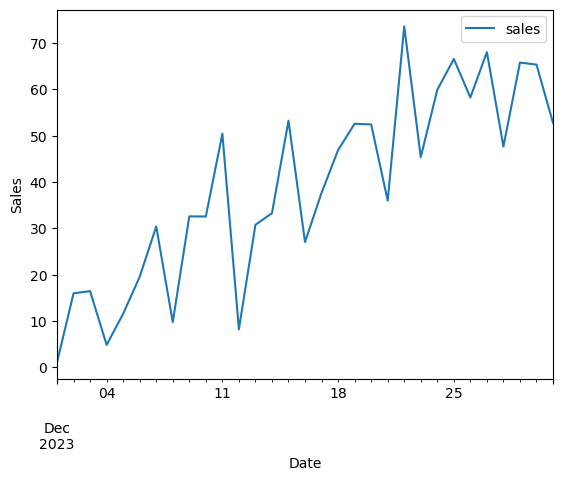

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Random number seed for repeatability
rng = np.random.default_rng(seed=51)
# DataFrame with some amount of daily data
dates = pd.date_range(start='2023-12-01', end='2023-12-31', freq='D')
sales = rng.normal(loc=2, scale=0.05, size=len(dates)) * np.arange(len(dates)) + rng.normal(loc=10, scale=10, size=len(dates))
df = pd.DataFrame({'sales': sales}, index=dates)

df.plot(xlabel='Date', ylabel='Sales')
plt.savefig('data.png')
plt.show()

## First model: Just a random guess
Perhaps the simplest way to predict what the next value would be is to just guess a number.
The data looks random, so just pick a random number between the minimum sales value and the maximum sales value.
The code below will do just that, but I don't think it will surprise anyone that we can do better.

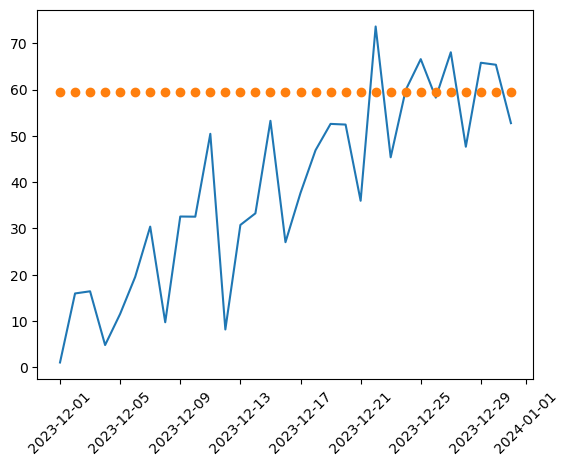

In [13]:
first_guess = rng.uniform(df['sales'].min(), df['sales'].max())

plt.figure()
plt.plot(dates, sales, label='sales')
plt.plot(dates, [first_guess]*len(dates), 'o', label='first guess')
plt.xticks(rotation=45)
plt.savefig('random_guess.png')
plt.show()

Okay, so there will be 59 sales every day, including the next day.
How sure are you? What is the error associated with that estimate?
There is no way to answer these questions with this method.
We can, and must do better.

## Second model: Mean

The mean model is only appropriate for time series data that is independently distributed, like drawing numbers out of a hat.
This is not the case for the data we are working with here, but it's important to see how the mean model works to understand the models that follow.
The sample mean, $\bar{X}$, is the average of all values in the sample:

$$\bar{X} = \frac{1}{n} \sum_{i=1}^n x_i$$

There is another measure associated with the mean and the data, and it's a measure of the average squared deviation from the mean, called the variance:

$$s^2 = \frac{1}{n-1} \sum_{i=1}^n \left(x_i-\bar{X}\right)^2$$

The square root of the variance is the sample standard deviation.
These values are both calculated for us using the `.describe()` method.

In [4]:
df.describe()

,sales
count,31.000000
mean,38.916852
std,20.881096
min,1.064717
25%,23.282906
50%,37.670628
75%,52.992109
max,73.613363


Using the mean model, we would predict a value of about 39 for every sale.
We can go a step further though, and estimate the error in our predictions.
Error comes from noise in the data and from our parameter estimation.
In this simple model, the standard error of the model is the standard deviation, and the standard error of the mean accounts for the parameter risk.

$$SE_{\textrm{forecast}} = \sqrt{s^2 + SE_{\textrm{mean}}^2}$$

Note that the standard error of the mean, $SE_{\textrm{mean}}=s/\sqrt{n}$.

We can use `statsmodels` to calculate this for us automatically.

In [5]:
import statsmodels.api as sm

model = sm.OLS(sales, np.ones(len(sales)))
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 14 Dec 2023   Prob (F-statistic):                nan
Time:                        01:17:12   Log-Likelihood:                -137.68
No. Observations:                  31   AIC:                             277.4
Df Residuals:                      30   BIC:                             278.8
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.9169      3.750     10.377      0.0

Looking closely at the output above, we can see that the mean and standard error were calculated.
We can go a step further and visualize the prediction.

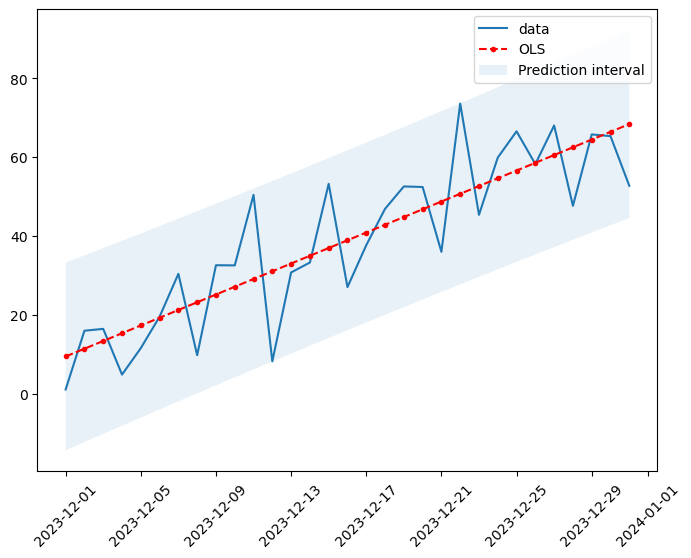

In [14]:
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(dates, sales, label="data")
ax.plot(dates, res.fittedvalues, "r--.", label="OLS")
ax.fill_between(dates, iv_u, iv_l, alpha=0.1, label='Prediction interval')
ax.legend(loc="best")
plt.xticks(rotation=45)
plt.savefig('mean.png')
plt.show()

## Third Model: Ordinary Least Squares
This data appears to be trending upward, so perhaps a linear model would better explain the data.
We can make a linear model with `statsmodels`.
This model uses the following form:

$$\bold{y} = \bold{X}\beta + \epsilon$$

where $\bold{y}$ is an $n\times 1$ vector of the response variable (sales), $\epsilon$ is an $n\times 1$ vector of errors.
$\bold{X}$ is an $n\times p$ matrix of regressors, and $\beta$ is a $p \times 1$ vector of unknowns that we want to find out.
Right now, our x data is simply the date, but we must add a new column of ones to the data using `sm.add_constant()` in order to
have a way to have an intercept in our model.

In [7]:
X = sm.add_constant(np.arange(len(sales)))
print(f"Note that the shape of X is now {X.shape}\n")
model = sm.OLS(sales, X)
res = model.fit()
print(res.summary())

Note that the shape of X is now (31, 2)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     79.45
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           8.39e-10
Time:                        01:17:12   Log-Likelihood:                -117.24
No. Observations:                  31   AIC:                             238.5
Df Residuals:                      29   BIC:                             241.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

This model did well! Our sales data was initialized with a slope of 2 and an intercept of 10 (plus some random noise).
The output of the OLS fit shows that the fitted values are quite close.
Below we visualize the data and observe that the prediction error has been reduced.

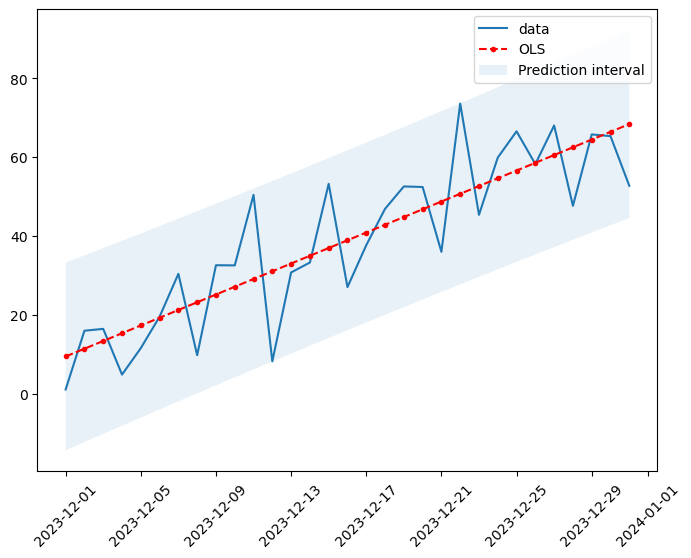

In [15]:
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(dates, sales, label="data")
ax.plot(dates, res.fittedvalues, "r--.", label="OLS")
ax.fill_between(dates, iv_u, iv_l, alpha=0.1, label='Prediction interval')
ax.legend(loc="best")
plt.xticks(rotation=45)
plt.savefig('OLS.png')
plt.show()